In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from scipy.optimize import curve_fit

plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=20)

In [2]:
Nmax = 10
nu = 1.
Delta = 1.
kappa = .1

sim_time = 16 * 2*np.pi
trot_steps = 160

pi_time_blue = 184.4944
sideband_Rabi_heat = np.pi/pi_time_blue * 1e6

In [3]:
def get_pops(t, nbar):
    H = Delta/2 * tensor(sigmax(), qeye(Nmax))
    H += kappa/2 * tensor(sigmaz(), (destroy(Nmax) + create(Nmax)))  
    H += nu * tensor(qeye(2), create(Nmax) * destroy(Nmax))
    
    init_state = tensor(ket2dm(basis(2,0)), thermal_dm(Nmax, nbar))
    e_op = tensor(ket2dm(basis(2,0)), qeye(Nmax))
    
    result = mesolve(H, init_state, t, e_ops=[e_op])
    return result.expect[0]

In [4]:
def get_pops_trot(nbar, heat_steps, seed):
    np.random.seed(seed)
    heat_time = 2/sideband_Rabi_heat * np.sqrt(nbar * heat_steps) 

    tlist = np.linspace(0, heat_time, heat_steps+1)
    state = tensor(ket2dm(basis(2,0)), thermal_dm(Nmax, 0.))

    for i in range(heat_steps):
        tlist_cur = tlist[i:i+2]
        phase = np.random.uniform(high=2*np.pi)
        H = sideband_Rabi_heat / 2 * tensor(qeye(2), destroy(Nmax)) * np.exp(-1j * phase)
        H +=  sideband_Rabi_heat / 2 * tensor(qeye(2), create(Nmax)) * np.exp(1j * phase)
        state = mesolve(H, state, tlist_cur).states[-1]
    
    H = Delta/2 * tensor(sigmax(), qeye(Nmax))
    H += kappa/2 * tensor(sigmaz(), (destroy(Nmax) + create(Nmax))) 
    H += nu * tensor(qeye(2), create(Nmax) * destroy(Nmax))
    tlist = np.linspace(0, sim_time, trot_steps+1)
    e_op = tensor(ket2dm(basis(2,0)), qeye(Nmax))
    pops = mesolve(H, state, tlist, e_ops=[e_op]).expect[0]
    
    return np.array(pops)

In [5]:
nbar = 1.
heat_steps = 5
trials = 10

pops_sim = get_pops(np.linspace(0, sim_time, trot_steps+1), nbar)

pops_trot = np.zeros((trials, trot_steps+1))
for i in range(trials):
    pops_trot[i,:] = get_pops_trot(nbar, heat_steps, i)   

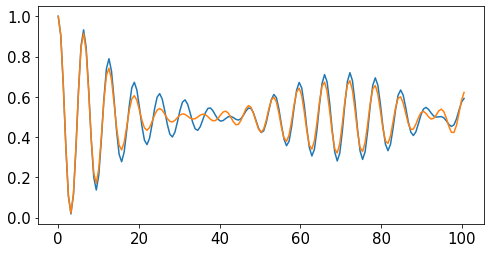

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.linspace(0, sim_time, trot_steps+1), pops_sim)
ax.plot(np.linspace(0, sim_time, trot_steps+1), np.mean(pops_trot, axis=0))

# Just directly measure $\bar{n}$

In [7]:
def get_nbar_kick(nbar, heat_steps, seed):
    np.random.seed(seed)
    heat_time = 2/sideband_Rabi_heat * np.sqrt(nbar * heat_steps) 

    tlist = np.linspace(0, heat_time, heat_steps+1)
    state = tensor(ket2dm(basis(2,0)), thermal_dm(Nmax, 0.))

    for i in range(heat_steps):
        tlist_cur = tlist[i:i+2]
        phase = np.random.uniform(high=2*np.pi)
        H = sideband_Rabi_heat / 2 * tensor(qeye(2), destroy(Nmax)) * np.exp(-1j * phase)
        H +=  sideband_Rabi_heat / 2 * tensor(qeye(2), create(Nmax)) * np.exp(1j * phase)
        state = mesolve(H, state, tlist_cur).states[-1]
    
    e_op = tensor(qeye(2), create(Nmax) * destroy(Nmax))
    return (state * e_op).tr()

In [8]:
heat_steps = 5
nbar_list = [0.25, 0.5, 1., 2.]
batch_size_list = [20, 200]

nbar_mean_list = np.zeros((len(nbar_list), len(batch_size_list)))
nbar_std_list = np.zeros((len(nbar_list), len(batch_size_list)))

for i in range(len(nbar_list)):
    nbar = nbar_list[i]
    nbar_kick = np.load('./data/heattest_nbar=%.2f_step%d.npy'%(nbar, heat_steps))  
    for j in range(len(batch_size_list)):
        batch_size = batch_size_list[j]
        num_batch = len(nbar_kick) // batch_size
        print('nbar: ', nbar, ' batch size: ', batch_size)
        
        nbar_kick_batch = []
        for k in tqdm(range(num_batch)):
            nbar_kick_batch += [np.mean(nbar_kick[batch_size*k:batch_size*(k+1)])]
        print(len(nbar_kick_batch))
            
        nbar_mean_list[i,j] = np.mean(nbar_kick_batch)
        nbar_std_list[i,j] = np.std(nbar_kick_batch)

nbar:  0.25  batch size:  20


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50057.33it/s]


100
nbar:  0.25  batch size:  200


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 9943.82it/s]


10
nbar:  0.5  batch size:  20


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50117.15it/s]


100
nbar:  0.5  batch size:  200


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10017.44it/s]


10
nbar:  1.0  batch size:  20


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50171.10it/s]


100
nbar:  1.0  batch size:  200


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]


10
nbar:  2.0  batch size:  20


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 24902.36it/s]


100
nbar:  2.0  batch size:  200


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10015.05it/s]

10


In [9]:
print(nbar_mean_list)
print(nbar_std_list)

[[0.25387975 0.25387975]
 [0.50775705 0.50775705]
 [1.01509032 1.01509032]
 [1.99466128 1.99466128]]
[[0.048823   0.00920853]
 [0.09764478 0.01841687]
 [0.19499227 0.03678655]
 [0.36839169 0.07045805]]
